# Setting Alerts

In [1]:
import pandas as pd
from datetime import datetime as dt, timedelta as td
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Load all the data
users = pd.read_csv('users.csv', index_col=0)
products = pd.read_csv('products.csv', index_col=0)
orders = pd.read_csv('orders.csv', index_col=0)
orders.rename(columns={'date': 'datetime'}, inplace=True) # Changing date column name to datetime as i'll be requiring "date" later

### Exploration

In [3]:
orders.head()

,oid,pid,qty,uid,datetime,total
0,0,13,2,1,2019-01-26 00:32:50,159.50
1,1,1,3,1,2019-01-25 03:45:10,158.85
2,2,5,4,1,2018-01-11 00:03:37,16.96
3,3,1,3,1,2019-01-15 15:11:29,158.85
4,4,9,1,1,2019-01-24 18:26:10,31.29


In [4]:
users.head()

,uid,uname,city
0,1,User 1,City 21
1,2,User 2,City 22
2,3,User 3,City 15
3,4,User 4,City 2
4,5,User 5,City 24


In [5]:
products.head()

,pid,pname,category,price
0,1,Product 1,Category 3,52.95
1,2,Product 2,Category 1,9.28
2,3,Product 3,Category 1,65.40
3,4,Product 4,Category 1,9.92
4,5,Product 5,Category 4,4.24


### Preparation

In [6]:
# Function to split the string format of time to individual time components
def get_time_units(time_string):
    date = time_string.split(' ')[0]
    time = time_string.split(' ')[1]
    y, m, d = date.split('-')
    H, M, S = time.split(':')
    return y, m, d, H, M, S

In [7]:
for i, row in orders.iterrows():# Note: This is extremely slow for larger datasets. The right way to do this is with df.apply()
    y, m, d, H, M, S = get_time_units(row['datetime'])
    orders.at[i, 'year'] = y
    orders.at[i, 'month'] = m
    orders.at[i, 'day'] = d
    orders.at[i, 'hour'] = H
    orders.at[i, 'min'] = M
    orders.at[i, 'sec'] = S
    

In [8]:
transaction_data = orders[['oid', 'pid', 'uid', 'qty', 'total', 'year', 'month', 'day', 'hour']].merge(
products, left_on='pid', right_on='pid', how='left').merge(users, left_on='uid', right_on='uid', how='left')

### Analysis

In [9]:
transaction_data[['qty', 'total']].describe()

,qty,total
count,624151.000000,624151.000000
mean,2.499009,123.315240
std,1.118163,96.417321
min,1.000000,4.240000
25%,1.000000,39.680000
50%,2.000000,93.870000
75%,3.000000,189.580000
max,4.000000,379.160000


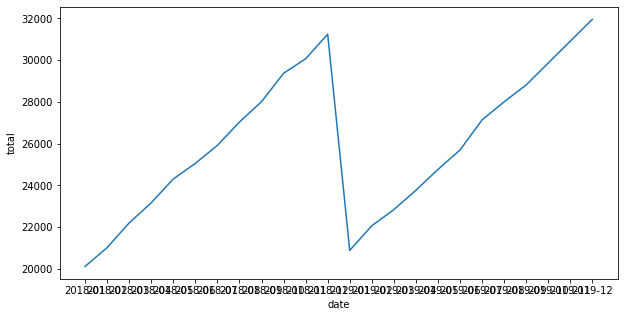

In [10]:
plt.figure(figsize=(10,5)) # Set up the plot dimensions
monthly_transactions = transaction_data.groupby(['year', 'month'])['total'].count().reset_index().sort_values(['year', 'month'], ascending=[1,1])
# sum up all transactions in a month
monthly_transactions['date'] = monthly_transactions['year']+'-'+monthly_transactions['month']
# create a column with just year and month for easier plotting
sns.lineplot(x='date', y='total', data=monthly_transactions)

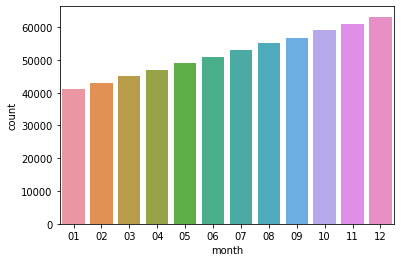

In [11]:
sns.countplot(x='month', data=orders) # Plot the whole data as counts in each month

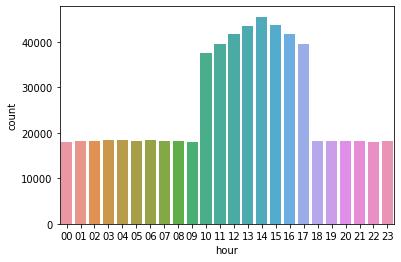

In [12]:
sns.countplot(x='hour', data=orders) # Plot as counts in each hour

In [13]:
hourly = transaction_data.groupby(['year', 'month', 'day', 'hour']).agg({'total': ['sum', 'count']}).reset_index()
hourly.head() # Sum up the total order count and order value in each hour for each day in the two years

year month day hour    total      
                            sum count
0  2018    01  01   00  3209.45    26
1  2018    01  01   01  3516.83    23
2  2018    01  01   02  2056.05    19
3  2018    01  01   03  2646.48    19
4  2018    01  01   04  2791.20    25

count      696.000000
mean      6670.467658
std       1272.035294
min       2745.930000
10%       5040.415000
25%       5825.160000
50%       6610.045000
75%       7489.105000
80%       7730.910000
90%       8347.255000
96%       8953.534000
max      12123.080000
Name: (total, sum), dtype: float64

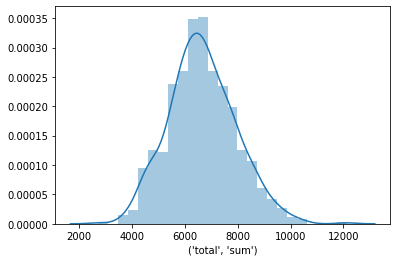

In [14]:
# Analyse what the hourly distribution of transactional metrics are
hour, metric = '10', 'sum'
per_hour = hourly[hourly.hour == hour]
sns.distplot(per_hour[('total', metric)])
per_hour[('total', metric)].describe(percentiles=[.10, .25, .5, .75, .8, .9, .96])
# These are the statistics for the 10th hour of every day for the entire period of measuring

/Users/zseijin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2894: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc[index, col] = value


count      701.000000
mean      6715.606976
std       1374.972500
min       2745.930000
10%       5042.260000
25%       5832.070000
50%       6615.650000
75%       7512.950000
80%       7767.140000
90%       8405.300000
96%       9145.980000
max      12999.000000
Name: (total, sum), dtype: float64

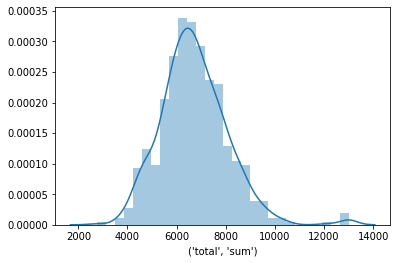

In [15]:
# Introduce some outliers
per_hour.at[2, ('total', metric)] = 12999
per_hour.at[7, ('total', metric)] = 12999
per_hour.at[11, ('total', metric)] = 12999
per_hour.at[13, ('total', metric)] = 12999
per_hour.at[15, ('total', metric)] = 12999
sns.distplot(per_hour[('total', metric)])
per_hour[('total', metric)].describe(percentiles=[.10, .25, .5, .75, .8, .9, .96])

In [16]:
print(per_hour[('total', metric)].describe(percentiles=[.95])['95%']) # This is one way to calculate a cut off

8917.410000000002
